In [1]:
import numpy as np
import time as time
import matplotlib.pyplot as plt
import math
import cmath
import gmpy2 as gp
from gmpy2 import mpc
import scipy as sp
from scipy import stats

gp.get_context().precision=500

In [2]:
#This function provides a list of the admissible colors for the given level set r:
def colors(r):
    I = [i for i in range((r-3)//2+1)]
    return I

#Primitive root of unity for which we are computing all of our invariants, as a function of the level set r:
def A(r):
    B = gp.exp(np.pi*1j/(r))
    return B
################################################################################################

################################################################
#Supporting functions for quantum integers and factorials
################################################################

def Q(n,A):
    z = (-A)**(n) - (-A)**(-n)
    return z.imag*1j

def Qp(n,A):
    z = (-A)**(n) + (-A)**(-n)
    return z.real
def f1(N,A):
    if N==0:
        return 1
    elif N>0:
        return np.prod([Q(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f1p(N,A):
    if N==0:
        return 2
    elif N>0:
        return np.prod([Qp(i,A) for i in range(1,N+1)])
    else: 
        return 0
def f2(N,A):
    if N==0:
        return 1
    else:
        temp=1
        for i in range(N,0,-2):
            temp=temp*Q(i,A)
            continue
        return temp
def mu(n,A):
    return (-A)**(n*(n+2))
def lamb(n,A):
    return -Q(2*n+2,A)

################################################################################################

################################################################
#Functions used to construct the representations for C_R and C_L
################################################################
def R(c,n,m,A):
    x = f1(m,A)*f2(2*c+2*n+1,A)*f1p(2*c+n+1,A)
    y = f1(n,A)*f2(2*c+2*m+1,A)*f1p(2*c+m+1,A)
    return x/y

def Mminus(N,n,m,A):
    x = Q(m,A)*((-A)**(-2*N+2*m))
    y = Q(n+1,A)
    return x/y
def Mplus(N,n,m,A):
    x = ((-A)**(-2*N+2*m+2))*Q(-2*N+2*m+2,A)*Qp(-2*N+m+1,A)
    y = Q(n+1,A)
    return x/y
def Mmid1(c,N,n,m,A):
    x = (A-A**(-1))*(lamb(c+m,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)-Q(2,A)*lamb(c+n,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def Mmid(c,N,n,m,A):
    x = (A-A**(-1))*(Qp(2*N-2*m-1,A))**(2)+A*(Q(m+1,A)**(2))*R(c,m+1,m,A)-A**(-1)*(Q(m,A)**2)*R(c,m,m-1,A)+Q(2,A)*Qp(2*N-2*n-1,A)
    y = Q(2,A)*Q(n+1,A)
    return x/y

def makeM(N,c,n,A):
    bigM = np.zeros(shape=(N,N),dtype=mpc)
    bigM[0,0] = Mmid(c,N,n,0,A)
    bigM[0,1] = Mplus(N,n,0,A)
    bigM[N-1,N-2] = Mminus(N,n,N-1,A)
    bigM[N-1,N-1] = Mmid(c,N,n,N-1,A)
    for m in range(1,N-1):
        bigM[m,m] = Mmid(c,N,n,m,A)
        bigM[m,m-1] = Mminus(N,n,m,A)
        bigM[m,m+1] = Mplus(N,n,m,A)
    return bigM

################################################################################################

################################################################
#Build libraries for R and L representations
################################################################

def makeRepR(N,c,A):
    S = np.zeros(shape=(N,N),dtype = mpc)
    S[0,0] = 1
    for n in range(1,N):
        M = makeM(N,c,n-1,A)
        S[:,n] = M.dot(S[:,n-1])
    return S


In [23]:
test = np.array(range(313))
test = test[test %4==3]
############################################################################################
def cc(r):
    return (r-3)//4

def libRmid(array):
    lib = {}
    for r in array:
        repsr = makeRepR((r-1)//2-cc(r),cc(r),A(r))
        lib[r] = repsr
    return lib

time_start = time.process_time()

Rlibmid = libRmid(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build R Library: %s seconds' % time_elapsed)

#Once we have the R rep library, we can construct the corresponding library of L reps using these two functions:

def makeRepLmid(N,r,A):
    repR = Rlibmid[r]
    c=cc(r)
    S = np.linalg.inv(np.array([[repR[m,n]/R(c,n,m,A) for m in range(N)] for n in range(N)],dtype=complex)).astype(mpc)
    return S

def libLmid(array):
    lib = {}
    for r in array:
        repsr = makeRepLmid((r-1)//2-cc(r),r,A(r))
        lib[r] = repsr
    return lib

time_start = time.process_time()

Llibmid = libLmid(test)

time_elapsed = (time.process_time() - time_start)
print('Time to build L Library: %s seconds' % time_elapsed)

def midRep(r,string):
    #r >= 3 is odd TV parameter
    #c is color from list of colors, N = (r-1)/2 - c
    #k is choice of primitive 2r root of unity 
    #string is the string of L's and R's 
    N = (r-1)//2-cc(r)
    if 'R' in string:
        repR = Rlibmid[r]
    if 'L' in string:
        repL = Llibmid[r]
    rho = np.zeros(shape=(N,N), dtype=mpc)
    first = string[0]
    if first == 'L':
        rho = repL
    else: 
        rho = repR
    for char in string[1:]:
        if char == 'L':
            rho = rho.dot(repL)
        else:
            rho = rho.dot(repR)
    return rho

def midRepVals(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        valr = (2*np.pi)/(r)*gp.log(abs(np.trace(midRep(r,string)))**2)
        print(r,valr)
        x[i] = r
        y[i] = valr
        i=i+1
    return x,y

def midRepValsTV(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        valr = abs(np.trace(midRep(r,string)))**2
        print(r,valr)
        x[i] = r
        y[i] = valr
        i=i+1
    return x,y

def midRepVal(r, string):
    return (2*np.pi)/(r)*gp.log(abs(np.trace(midRep(r,string)))**2)

def midRepValTV(r, string):
    return abs(np.trace(midRep(r,string)))**2

def genRLn(n):
    x = ''
    for i in range(n):
        x = x+ 'RL'
    return x

def midRepEValSum(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        evalr = sum(sorted(abs(np.array(np.linalg.eig(midRep(r,string).astype(complex))[0])),reverse=True))
        print(r,evalr)
        x[i] = r
        y[i] = evalr
        i=i+1
    return x,y

def midRepTopEVal(array, string):
    x = np.zeros(shape = (len(array),))
    y = np.zeros(shape = (len(array),))
    i=0
    for r in array:
        evalr = sorted(abs(np.array(np.linalg.eig(midRep(r,string).astype(complex))[0])),reverse=True)[0]
        print(r,evalr)
        x[i] = r
        y[i] = evalr
        i=i+1
    return x,y

Time to build R Library: 12120.46875 seconds
Time to build L Library: 5996.171875 seconds


3 0.0
7 1.4533670330791349625645225825788591712700818989240383363726398782479070881612764384032456181875628879645905513868173541145258824880224809624987990057472
11 1.647218562018233224785710888773982314238798098934839092884702599263700822870094319867362479063788897787870704151903817188900924248186668381258367001188
15 1.7143549747961824418354164545010868831263056535565378854604879616844152036784207647495720195037889261279115090323324733927139964210654631158055061459637
19 1.7553987295439034300196902410220171325551827283086479965184577805122364432947902354902118912212857844644854521228015904864122157926686549150475616859872
23 1.7870541466256491753447696701382407311236764419801381058957656433991419726272382268576063427550762540549664201935572056349743677277062702369884772638788
27 1.8130994739471899129084841425638951232118125532729395020021948617896382141104550921196679815988882594774170468228880146737242977297712439052546633007756
31 1.8348778859601235508772524543839503953780581960175

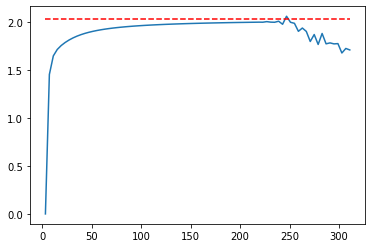

In [24]:
x,y = midRepVals(test[test <313],'RL')
vol = np.array([2.029883128 for i in range(len(x))])
plt.plot(x,y)
plt.plot(x,vol,'r--')
plt.show()

3 1.0
7 1.6355731299222205
11 2.881688664511584
15 5.367138364575822
19 10.14080112584245
23 19.240893386638554
27 36.573757379526725
31 69.59216168968842
35 132.50629358091248
39 252.41080061604714
43 480.9712351598253
47 916.7138472870118
51 1747.5407767881825
55 3331.8257531669033
59 6353.105265168543
63 12115.162495934845
67 23104.934118197503
71 44066.34402048683
75 84048.8512575741
79 160315.5246615282
83 305798.7076735087
87 583323.8311754423
91 1112745.7488381274
95 2122720.309210976
99 4049476.852799902
103 7725263.300252054
107 14737877.995670425
111 28116621.074247546
115 53641031.65800735
119 102337864.11839011
123 195245168.384135
127 372501919.71933997
131 710690663.1933043
135 1355926804.199128
139 2586992147.9602385
143 4935792764.236235
147 9417192347.948383
151 17967532237.087105
155 34281347879.85879
159 65407791835.648636
163 124796666231.36952
167 238110169873.2718
171 454318879571.2698
175 866841022279.3005
179 1653930339267.4185
183 3155407387332.1523
187 6021129

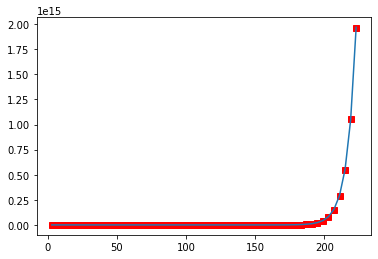

3 1.0
7 1.6355731299222205
11 2.881688664511584
15 5.367138364575822
19 10.14080112584245
23 19.240893386638554
27 36.573757379526725
31 69.59216168968842
35 132.50629358091248
39 252.41080061604714
43 480.9712351598253
47 916.7138472870118
51 1747.5407767881825
55 3331.8257531669033
59 6353.105265168543
63 12115.162495934845
67 23104.934118197503
71 44066.34402048683
75 84048.8512575741
79 160315.5246615282
83 305798.7076735087
87 583323.8311754423
91 1112745.7488381274
95 2122720.309210976
99 4049476.852799902
103 7725263.300252054
107 14737877.995670425
111 28116621.074247546
115 53641031.65800735
119 102337864.11839011
123 195245168.384135
127 372501919.71933997
131 710690663.1933043
135 1355926804.199128
139 2586992147.9602385
143 4935792764.236235
147 9417192347.948383
151 17967532237.087105
155 34281347879.85879
159 65407791835.648636
163 124796666231.36952
167 238110169873.2718
171 454318879571.2698
175 866841022279.3005
179 1653930339267.4185
183 3155407387332.1523
187 6021129

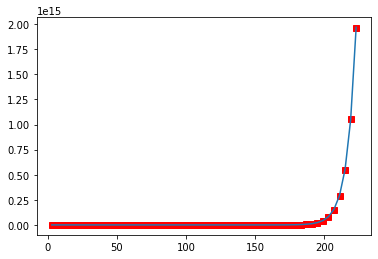

True
True


In [27]:
x,y = midRepTopEVal(test[test <225],'RL')
plt.plot(x,y,'rs')


fit = sp.optimize.curve_fit(lambda t,a,b: a*np.exp(b*t),  x,  y,  p0=(1, 0.15))
a = fit[0][0]
b = fit[0][1]
print('------------------------------')
print(a,b)
fity = [a*np.exp(b*t) for t in x]
plt.plot(x,fity)

plt.show()
plt.close()

xs,ys = midRepTopEVal(test[test <225],'RL')
plt.plot(x,y,'rs')

fits = sp.optimize.curve_fit(lambda t,aa,bb: aa*np.exp(bb*t),  xs,  ys,  p0=(1, 0.15))
aa = fits[0][0]
bb = fits[0][1]
print('------------------------------')
print(aa,bb)
fitys = [aa*np.exp(bb*t) for t in xs]
plt.plot(xs,fitys)


plt.show()

print(a==aa)
print(b==bb)

AttributeError: 'float' object has no attribute 'shape'

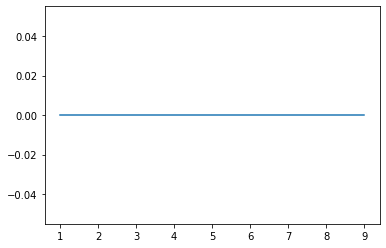

In [19]:
mfds = [genRLn(n) for n in range(1,10)]
x = range(1,len(mfds)+1)
for r in test:
    y = [midRepVal(r,word) for word in mfds]
    plt.plot(x,y)
    slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
    print("For r=%s, slope = %s and r_value = %s" %(r,slope,r_value))
plt.show()